# ViLT VQA Demo

This Notebook is based on the following: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViLT/Inference_with_ViLT_(visual_question_answering).ipynb

The most notable factors of Vilt is that it is much faster performance which is important for our goal of real time VQA:


![](https://media.arxiv-vanity.com/render-output/5709204/x1.png)
https://www.arxiv-vanity.com/papers/2102.03334/


In [46]:
from PIL import Image 
import numpy as np
from transformers import ViltForQuestionAnswering, ViltProcessor 
import torch

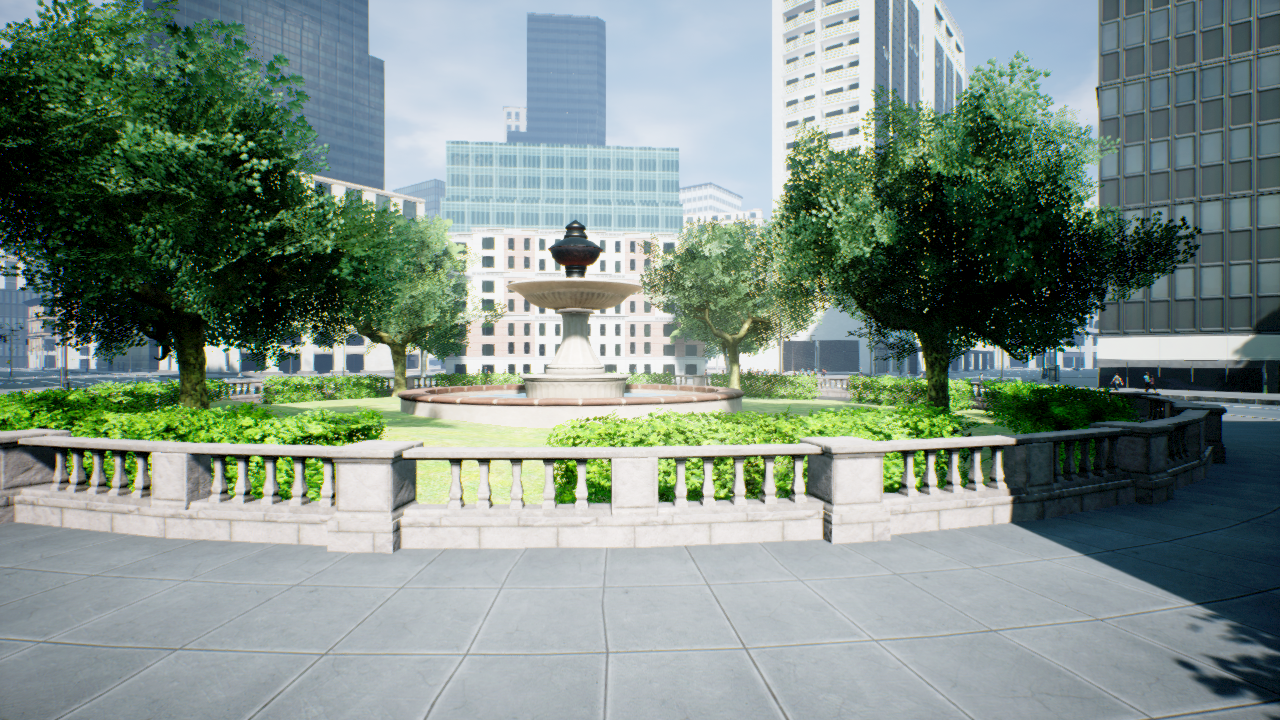

In [30]:
image_location = r"C:\Users\robin\Desktop\SeniorDesign2\VisualInspectionDeepLearning\ModelTesting\AirSimImage.png"
image = Image.open(image_location)
image

In [31]:
def getTopPredictions(vqa_raw_scores, vocab_dictionary):
    '''
    vqa_raw_scores is a Tensor containing the final classification scores of the model

    vocab_dictionary is a dictionary mapping the model output indicies to the corresponding words

    Returns a list of tuples with a word and corresponding score
    '''
    sm = torch.nn.Softmax(dim=0)
    probabilities = sm(vqa_raw_scores)
    top_answer_ids = probabilities.argsort()[-5:]
    top_predictions = []
    for id in top_answer_ids:
        id = int(id) # Type conversion to ensure we are working with ints and not tensors
        answer : str = vocab_dictionary[id]
        prob : float = probabilities[id]
        top_predictions.append((answer, prob))
    
    return top_predictions

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Performing VQA with the ViLT Model

In [33]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model.to(device)

# Prepare the input
question = "Is there a fountain?"
print(question)
encoding = processor(image, question, return_tensors="pt").to(device)

# forward pass
outputs = model(**encoding, output_attentions=True)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

top_predictions = getTopPredictions(logits[0], model.config.id2label)
for name, score in top_predictions:
    print(f"{name} {score:.5f}")


Is there a fountain?
Predicted answer: yes
unknown 0.00000
not sure 0.00000
y 0.00000
no 0.00014
yes 0.99985


# Visualization of Attention

We obtain the attention mapping for each token of input text. This creates of images containing attention based on each token. These individual images are combined to show the overall attention of the model.

Note: ViLT was not made with visual grounding in mind. It is possible that the model may be focusing on incorrect aspects of an image when making its predictions.

Based on: https://huggingface.co/spaces/MikailDuzenli/vilt_demo/blob/main/app.py


In [34]:
import torch.nn.functional as F

def cost_matrix_cosine(x, y, eps=1e-5):
    """Compute cosine distnace across every pairs of x, y (batched)
    [B, L_x, D] [B, L_y, D] -> [B, Lx, Ly]"""
    assert x.dim() == y.dim()
    assert x.size(0) == y.size(0)
    assert x.size(2) == y.size(2)
    x_norm = F.normalize(x, p=2, dim=-1, eps=eps)
    y_norm = F.normalize(y, p=2, dim=-1, eps=eps)
    cosine_sim = x_norm.matmul(y_norm.transpose(1, 2))
    cosine_dist = 1 - cosine_sim
    return cosine_dist


@torch.no_grad()
def ipot(C, x_len, x_pad, y_len, y_pad, joint_pad, beta, iteration, k):
    """ [B, M, N], [B], [B, M], [B], [B, N], [B, M, N]"""
    b, m, n = C.size()
    sigma = torch.ones(b, m, dtype=C.dtype,
                       device=C.device) / x_len.unsqueeze(1)
    T = torch.ones(b, n, m, dtype=C.dtype, device=C.device)
    A = torch.exp(-C.transpose(1, 2) / beta)

    # mask padded positions
    sigma.masked_fill_(x_pad, 0)
    joint_pad = joint_pad.transpose(1, 2)
    T.masked_fill_(joint_pad, 0)
    A.masked_fill_(joint_pad, 0)

    # broadcastable lengths
    x_len = x_len.unsqueeze(1).unsqueeze(2)
    y_len = y_len.unsqueeze(1).unsqueeze(2)

    # mask to zero out padding in delta and sigma
    x_mask = (x_pad.to(C.dtype) * 1e4).unsqueeze(1)
    y_mask = (y_pad.to(C.dtype) * 1e4).unsqueeze(1)

    for _ in range(iteration):
        Q = A * T  # bs * n * m
        sigma = sigma.view(b, m, 1)
        for _ in range(k):
            delta = 1 / (y_len * Q.matmul(sigma).view(b, 1, n) + y_mask)
            sigma = 1 / (x_len * delta.matmul(Q) + x_mask)
        T = delta.view(b, n, 1) * Q * sigma
    T.masked_fill_(joint_pad, 0)
    return T

def get_model_embedding_and_mask(model, input_ids, pixel_values):

    input_shape = input_ids.size()

    text_batch_size, seq_length = input_shape
    device = input_ids.device
    attention_mask = torch.ones(((text_batch_size, seq_length)), device=device)
    image_batch_size = pixel_values.shape[0]
    image_token_type_idx = 1

    if image_batch_size != text_batch_size:
        raise ValueError(
            "The text inputs and image inputs need to have the same batch size")

    pixel_mask = torch.ones((image_batch_size, model.vilt.config.image_size,
                            model.vilt.config.image_size), device=device)

    text_embeds = model.vilt.embeddings.text_embeddings(
        input_ids=input_ids, token_type_ids=None, inputs_embeds=None)

    image_embeds, image_masks, patch_index = model.vilt.embeddings.visual_embed(
        pixel_values=pixel_values, pixel_mask=pixel_mask, max_image_length=model.vilt.config.max_image_length
    )
    text_embeds = text_embeds + model.vilt.embeddings.token_type_embeddings(
        torch.zeros_like(attention_mask, dtype=torch.long,
                         device=text_embeds.device)
    )
    image_embeds = image_embeds + model.vilt.embeddings.token_type_embeddings(
        torch.full_like(image_masks, image_token_type_idx,
                        dtype=torch.long, device=text_embeds.device)
    )

    return text_embeds, image_embeds, attention_mask, image_masks, patch_index

c:\Users\robin\Desktop\SeniorDesign2\VisualInspectionDeepLearning\ModelTesting\Testing_Venv\lib\site-packages\torch\_tensor.py:958: RuntimeWarning: invalid value encountered in cast
  return self.numpy().astype(dtype, copy=False)


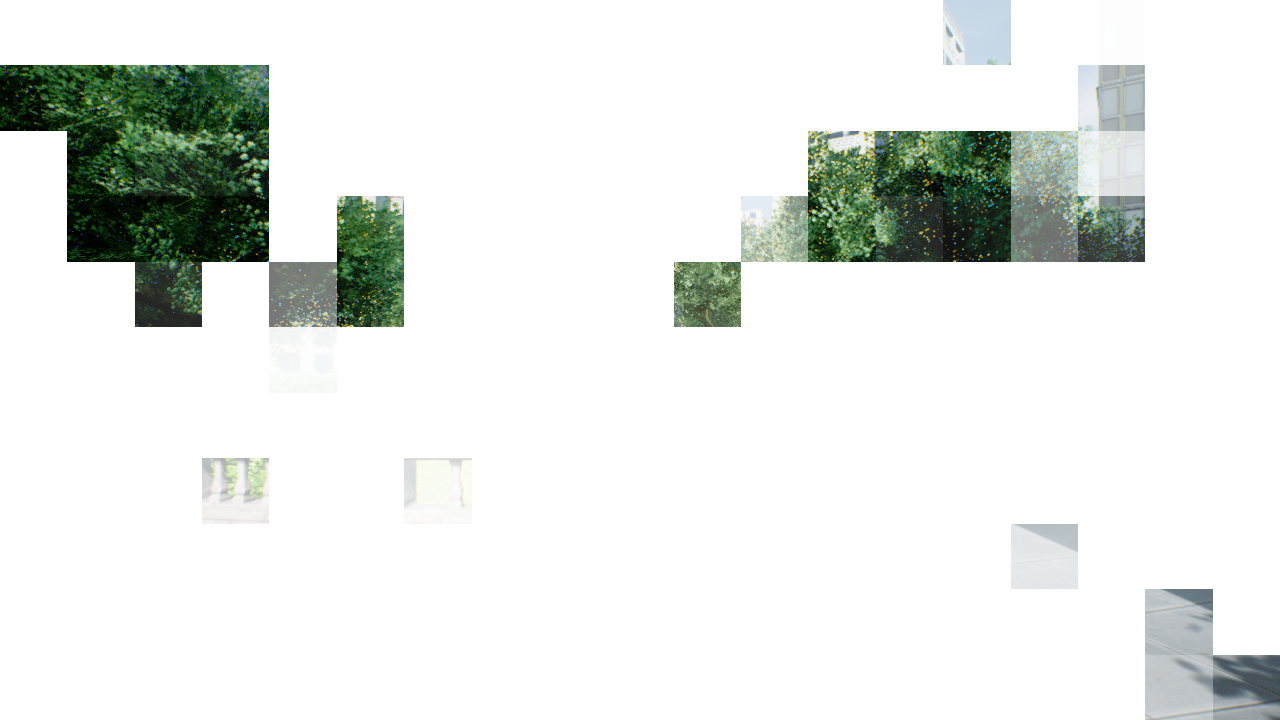

In [35]:
def get_visualization_for_token(model, encoding):
    txt_emb, img_emb, text_masks, image_masks, patch_index = get_model_embedding_and_mask(
            model, input_ids=encoding['input_ids'], pixel_values=encoding['pixel_values'])

    number_tokens = len(encoding['input_ids'][0])
    input_ids = encoding['input_ids']

    embedding_output = torch.cat([txt_emb, img_emb], dim=1)
    attention_mask = torch.cat([text_masks, image_masks], dim=1)

    extended_attention_mask = model.vilt.get_extended_attention_mask(
        attention_mask, input_ids.size(), device=device)

    encoder_outputs = model.vilt.encoder(
        embedding_output,
        attention_mask=extended_attention_mask,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=True,
        return_dict=True,
    )

    x = encoder_outputs.hidden_states[-1]
    x = model.vilt.layernorm(x)

    txt_emb, img_emb = (
        x[:, :txt_emb.shape[1]],
        x[:, txt_emb.shape[1]:],
    )

    txt_mask, img_mask = (
        text_masks.bool(),
        image_masks.bool(),
    )

    for i, _len in enumerate(txt_mask.sum(dim=1)):
        txt_mask[i, _len - 1] = False
    txt_mask[:, 0] = False
    img_mask[:, 0] = False
    txt_pad, img_pad = ~txt_mask, ~img_mask
    cost = cost_matrix_cosine(txt_emb.float(), img_emb.float())
    joint_pad = txt_pad.unsqueeze(-1) | img_pad.unsqueeze(-2)
    cost.masked_fill_(joint_pad, 0)

    txt_len = (txt_pad.size(1) - txt_pad.sum(dim=1,
                keepdim=False)).to(dtype=cost.dtype)
    img_len = (img_pad.size(1) - img_pad.sum(dim=1,
                keepdim=False)).to(dtype=cost.dtype)
    T = ipot(cost.detach(),
                txt_len,
                txt_pad,
                img_len,
                img_pad,
                joint_pad,
                0.1,
                1000,
                1,
                )
    plan = T[0]
    plan_single = plan * len(txt_emb)

    # Contains the costs for each token
    original_cost_ = plan_single.t()

    # Obtain the indices for all of the images patches
    patch_index, (H, W) = patch_index

    overlays = []
    results = []

    # Obtain all the attention maps for each token
    for hidx in range(number_tokens):
        cost_ = original_cost_[hidx][1:].to(device)

        heatmap = torch.zeros(H, W)
        for i, pidx in enumerate(patch_index[0]):
            h, w = pidx[0].item(), pidx[1].item()
            heatmap[h, w] = cost_[i]

        heatmap = (heatmap - heatmap.mean()) / heatmap.std()
        heatmap = np.clip(heatmap, 1.0, 3.0)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        _w, _h = image.size
        overlay = Image.fromarray(np.uint8(heatmap * 255), "L").resize(
            (_w, _h), resample=Image.Resampling.NEAREST
        )

        image_rgba = image.copy()
        image_rgba.putalpha(overlay)
        result = image_rgba

        overlays.append(overlay)
        results.append(result)


    return overlays, results

overlays, results = get_visualization_for_token(model, encoding)

results[1]

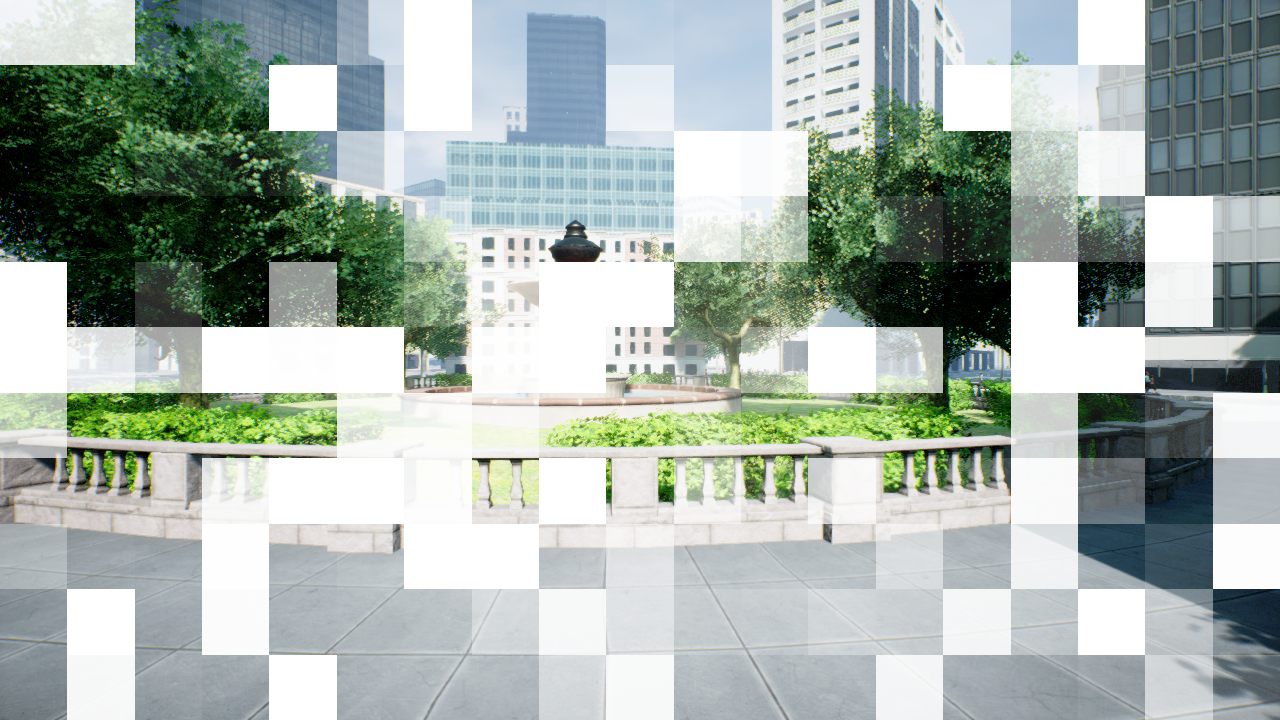

In [75]:
# Note: we need to make a copy of the image otherwise we'll overwrite this image
combined_image = results[0].copy()

for im in results[1:]:
    combined_image.paste(im, (0,0), im)

combined_image

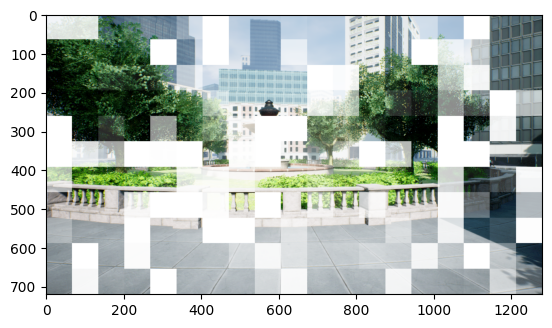

In [76]:
# Note: For our application we have to convert rbga -> rgb
# https://stackoverflow.com/questions/50331463/convert-rgba-to-rgb-in-python
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

cv2_image = rgba2rgb(np.array(combined_image))

import matplotlib.pyplot as plt
plt.imshow(cv2_image)


# Display of the input tokens for the model

Note: We show the encoded tokens and the decoded words

In [38]:
print(type(encoding))
print(type(encoding['input_ids']))

print(encoding['input_ids'].tolist()[0])
processor.batch_decode(encoding['input_ids'])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'torch.Tensor'>
[101, 2003, 2045, 1037, 9545, 1029, 102]


['[CLS] is there a fountain? [SEP]']